In [2]:
!pip install imblearn

   -------------------------------------- 258.0/258.0 kB 610.2 kB/s eta 0:00:00
   -------------------------------------- 301.2/301.2 kB 620.4 kB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.7.0 requires numba<1,>=0.56.0, but you have numba 0.55.1 which is incompatible.


In [26]:
import pandas as pd
import re
import numpy as np
import imblearn
from gensim.models import Word2Vec
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sync\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sync\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def clean_and_preprocess(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9]', ' ', text)
    words = text.lower().split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [4]:
file_path = 'text_emotion.csv'
data = pd.read_csv(file_path)

data.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   author     40000 non-null  object
 3   content    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [12]:
!pip install nltk

In [23]:
import nltk
nltk.download()
nltk.download('omw')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package omw to
[nltk_data]     C:\Users\Sync\AppData\Roaming\nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

In [6]:
data.drop(columns=['tweet_id'], inplace=True)
data.drop_duplicates(keep="first", inplace=True)
data.dropna(inplace=True)

data['cleaned_content'] = data['content'].apply(clean_and_preprocess)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39987 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentiment        39987 non-null  object
 1   author           39987 non-null  object
 2   content          39987 non-null  object
 3   cleaned_content  39987 non-null  object
dtypes: object(4)
memory usage: 1.5+ MB


In [7]:
data.head(n=100)

,sentiment,author,content,cleaned_content
0,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,know listenin bad habit earlier started freaki...
1,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,layin n bed headache ughhhh waitin call
2,sadness,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday
3,enthusiasm,czareaquino,wants to hang out with friends SOON!,want hang friend soon
4,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,want trade someone houston ticket one
...,...,...,...,...
95,sadness,yellowduckx,@sweeetnspicy hiii im on my ipod...i cant fall...,hiii im ipod cant fall asleep
96,sadness,KaKuBby,dont wanna work 11-830 tomorrow but i get paid,dont wanna work 11 830 tomorrow get paid
97,sadness,benchidol,feels sad coz i wasnt able to play with the gu...,feel sad coz wasnt able play guy
98,neutral,outrAjusCharmer,PrinceCharming,princecharming


In [8]:
w2v_data = [text.split() for text in data['cleaned_content']]

w2v_model = Word2Vec(w2v_data, vector_size=150, window=10, min_count=2, workers=4)

In [9]:
def text_to_vector(text):
    words = text.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv.key_to_index]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)


vectorized_texts = np.array([text_to_vector(text) for text in data['cleaned_content']])

In [10]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(vectorized_texts, data['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [11]:
def ouput_result(y_pred):
  print('Accuracy:', accuracy_score(y_test, y_pred))
  print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))
  print('Classification Report:\n', classification_report(y_test, y_pred))

In [35]:
svm = SVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
ouput_result(y_pred)

Accuracy: 0.1763369995992341
F1 Score: 0.1585035969175728
Classification Report:
               precision    recall  f1-score   support

       anger       0.14      0.34      0.19      1745
     boredom       0.18      0.42      0.25      1784
       empty       0.18      0.12      0.15      1756
  enthusiasm       0.20      0.10      0.13      1701
         fun       0.14      0.16      0.15      1686
   happiness       0.17      0.12      0.14      1733
        hate       0.19      0.25      0.21      1699
        love       0.34      0.38      0.36      1716
     neutral       0.18      0.02      0.04      1779
      relief       0.16      0.14      0.15      1732
     sadness       0.21      0.06      0.09      1710
    surprise       0.13      0.11      0.12      1716
       worry       0.13      0.05      0.07      1700

    accuracy                           0.18     22457
   macro avg       0.18      0.18      0.16     22457
weighted avg       0.18      0.18      0.16     2245

In [36]:
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)  # Логарифмическое пространство между 1 и 1e-9
}


grid_search = GridSearchCV(GaussianNB(), param_grid, cv=3, scoring='f1_weighted', n_jobs=8)
grid_search.fit(X_train, y_train)


best_gnb = grid_search.best_estimator_
y_pred = best_gnb.predict(X_test)
ouput_result(y_pred)

Accuracy: 0.12610767244066437
F1 Score: 0.10227369577335252
Classification Report:
               precision    recall  f1-score   support

       anger       0.11      0.23      0.15      1745
     boredom       0.12      0.53      0.20      1784
       empty       0.20      0.10      0.13      1756
  enthusiasm       0.11      0.03      0.04      1701
         fun       0.12      0.04      0.06      1686
   happiness       0.12      0.04      0.06      1733
        hate       0.09      0.18      0.12      1699
        love       0.25      0.24      0.25      1716
     neutral       0.12      0.02      0.04      1779
      relief       0.14      0.11      0.13      1732
     sadness       0.12      0.04      0.06      1710
    surprise       0.09      0.04      0.06      1716
       worry       0.13      0.03      0.04      1700

    accuracy                           0.13     22457
   macro avg       0.13      0.12      0.10     22457
weighted avg       0.13      0.13      0.10     22

In [37]:
# AdaBoost 
param_grid = {'n_estimators': [25, 100], 'learning_rate': [0.01, 0.1, 1]}
grid_search = GridSearchCV(AdaBoostClassifier(), param_grid, cv=3, scoring='f1_weighted', n_jobs=8)
grid_search.fit(X_train, y_train)

# Оценка модели
best_ada = grid_search.best_estimator_
y_pred = best_ada.predict(X_test)
ouput_result(y_pred)

Accuracy: 0.1671193837110923
F1 Score: 0.1466642436127481
Classification Report:
               precision    recall  f1-score   support

       anger       0.31      0.34      0.33      1745
     boredom       0.22      0.49      0.30      1784
       empty       0.11      0.10      0.10      1756
  enthusiasm       0.14      0.13      0.13      1701
         fun       0.14      0.11      0.12      1686
   happiness       0.14      0.11      0.12      1733
        hate       0.13      0.20      0.16      1699
        love       0.17      0.37      0.23      1716
     neutral       0.13      0.08      0.10      1779
      relief       0.14      0.09      0.11      1732
     sadness       0.14      0.04      0.06      1710
    surprise       0.13      0.04      0.06      1716
       worry       0.09      0.05      0.07      1700

    accuracy                           0.17     22457
   macro avg       0.15      0.17      0.15     22457
weighted avg       0.15      0.17      0.15     2245

Accuracy: 0.7960101527363406
F1 Score: 0.7753258400671666
Classification Report:
               precision    recall  f1-score   support

       anger       0.99      0.99      0.99      1745
     boredom       0.97      1.00      0.99      1784
       empty       0.85      0.98      0.91      1756
  enthusiasm       0.89      0.99      0.94      1701
         fun       0.85      0.97      0.91      1686
   happiness       0.67      0.64      0.66      1733
        hate       0.86      0.99      0.92      1699
        love       0.76      0.81      0.79      1716
     neutral       0.38      0.22      0.28      1779
      relief       0.84      0.97      0.90      1732
     sadness       0.66      0.64      0.65      1710
    surprise       0.81      0.94      0.87      1716
       worry       0.39      0.23      0.29      1700

    accuracy                           0.80     22457
   macro avg       0.77      0.80      0.78     22457
weighted avg       0.77      0.80      0.78     2245

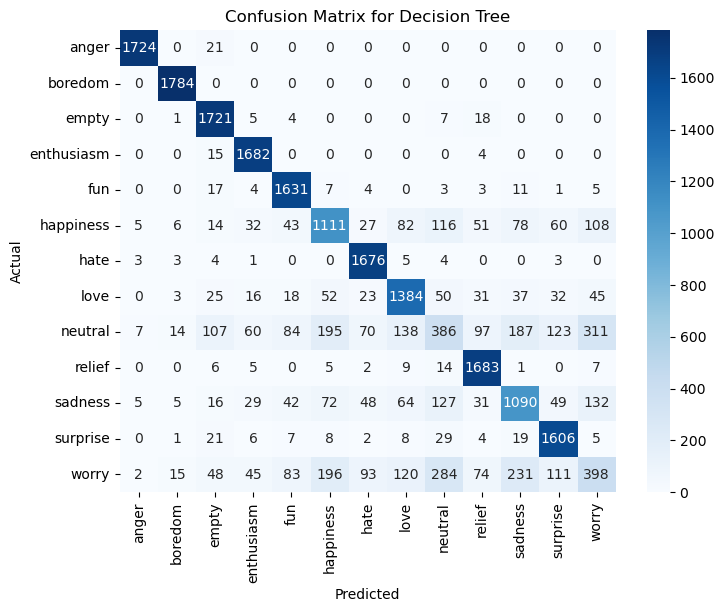

In [30]:
dt_params = {'max_depth': [10, 60]}
dt_model = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=5, scoring='f1_weighted')
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)
ouput_result(y_pred)

# Confusion matrix for Decision Tree
dt_conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(dt_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [39]:
knn_params = {'n_neighbors': [2, 50]}
knn_model = GridSearchCV(KNeighborsClassifier(), knn_params, cv=2, scoring='f1_weighted')
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)
ouput_result(y_pred)

C:\Users\Sync\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Sync\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

Accuracy: 0.7446675869439373
F1 Score: 0.7112992147165907
Classification Report:
               precision    recall  f1-score   support

       anger       0.90      1.00      0.95      1745
     boredom       0.97      1.00      0.99      1784
       empty       0.86      0.94      0.90      1756
  enthusiasm       0.84      0.99      0.91      1701
         fun       0.75      0.96      0.84      1686
   happiness       0.51      0.63      0.57      1733
        hate       0.82      0.98      0.89      1699
        love       0.68      0.74      0.71      1716
     neutral       0.29      0.19      0.23      1779
      relief       0.81      0.93      0.87      1732
     sadness       0.57      0.45      0.50      1710
    surprise       0.78      0.81      0.79      1716
       worry       0.38      0.06      0.10      1700

    accuracy                           0.74     22457
   macro avg       0.70      0.74      0.71     22457
weighted avg       0.71      0.74      0.71     2245

Accuracy: 0.8124415549717238
F1 Score: 0.7997676102629627
Classification Report:
               precision    recall  f1-score   support

       anger       1.00      0.99      0.99      1745
     boredom       0.99      1.00      1.00      1784
       empty       0.89      0.98      0.93      1756
  enthusiasm       0.94      0.99      0.97      1701
         fun       0.88      0.97      0.92      1686
   happiness       0.69      0.66      0.68      1733
        hate       0.89      0.99      0.94      1699
        love       0.77      0.83      0.80      1716
     neutral       0.43      0.28      0.34      1779
      relief       0.87      0.97      0.92      1732
     sadness       0.67      0.65      0.66      1710
    surprise       0.85      0.93      0.89      1716
       worry       0.41      0.34      0.37      1700

    accuracy                           0.81     22457
   macro avg       0.79      0.81      0.80     22457
weighted avg       0.79      0.81      0.80     2245

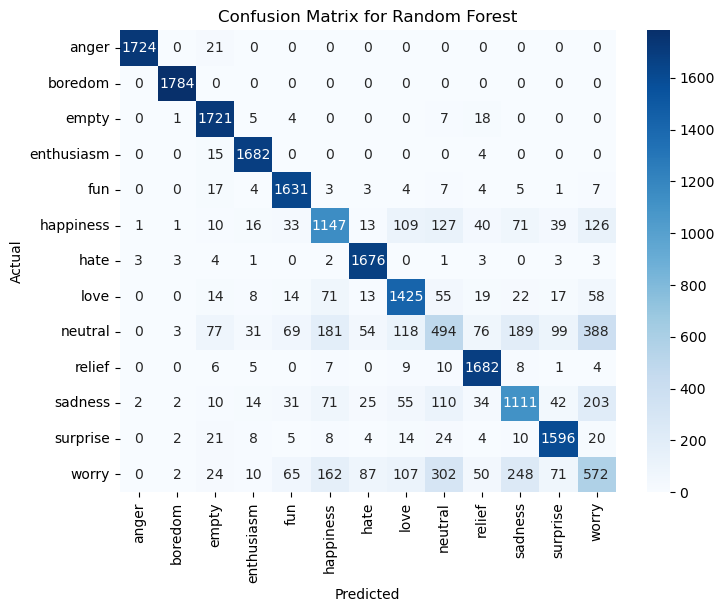

In [31]:
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
rf_model = GridSearchCV(RandomForestClassifier(), rf_params, cv=3, scoring='f1_weighted')
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
ouput_result(y_pred)

rf_conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()